# Predict Question Type

## 1. Business Problem and Understanding

In [31]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
np.random.seed(42)
random.seed(42)
import nltk
from nltk import pos_tag, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import itertools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import warnings
# warnings.filterwarnings("ignore")

## 2. Data Understanding

Our target will the be `qtype` or question type and we will try to match the `Question` column to be able to advice on appropriate next steps accoridng to the type of question being asked.

In [2]:
# Import dataset

df = pd.read_csv('train.csv')
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


No missingness to take care of.

In [3]:
df.isna().sum()

qtype       0
Question    0
Answer      0
dtype: int64

## 3. Data Exploration

### Target Variable `qtype`

Since we have some question types that have very few instances, we will have to drop that row before spliting our data if we want to keep class proportions. We will also have to consider our class imbalance when creating our models.

We can also use `LabelEncoder` to transform this variable before the train test split if we choose.

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
support groups        1
Name: count, dtype: int64


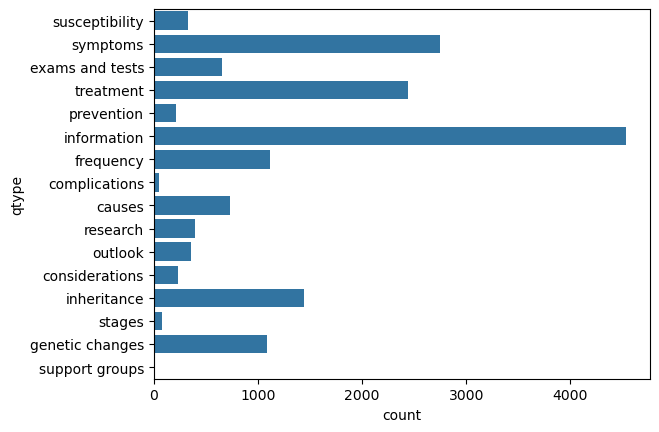

In [32]:
print(df['qtype'].value_counts())
sns.countplot(df['qtype']);

Transformer for easy text preprocessing.

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):

    # BaseEstimator and TransformerMixin are parents enable us to use this class in a pipeline
    # Could have made this into a function and would have to use FunctionTransformer to use in a pipeline
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

## 4. Data Preperation

In [6]:
# Identify index
index_drop = df[df['qtype']=='support groups'].index[0]

df_new = df.copy().drop(index_drop)

X = df_new['Question']
y = df_new['qtype']

# Label encode the target
le = LabelEncoder()
y = le.fit_transform(df_new['qtype'])

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

First we will try a Multinomial Naive Bayes model as it is great for text classification problems.

In [7]:
# Create preprocess pipeline

prc_steps = [('txtproc',TextPreprocessor()),
             ('tfid',TfidfVectorizer(min_df=.03,max_df=.98)),
             ('model', MultinomialNB())]

init_pipe = Pipeline(steps = prc_steps)

init_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', MultinomialNB())])

In [8]:
# Get the feature names from the vectorized X
feat_names = init_pipe['tfid'].get_feature_names_out()

X_train_trans = init_pipe.named_steps['tfid'].transform(X_train)

pd.DataFrame(X_train_trans.toarray(),columns=feat_names)

,affect,be,cancer,cause,change,deficiency,diagnose,disease,do,genetic,inherit,many,people,relate,symptoms,syndrome,treatments,type
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.63792,0.636277,0.0,0.000000,0.433831,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12299,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.743635,0.668586,0.000000,0.0
12300,0.0,0.0,0.0,0.0,0.0,0.818952,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.573863,0.000000,0.000000,0.0
12301,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.652746,0.757577,0.0
12302,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,1.000000,0.0


## 5. Naive Bayes Model

Lets check our baseline metrics then move on to cross validation and hyperparameter tuning.

Since we have a class imbalance, we will mostly be focusing on a weighted f1 score. Looking at our classification report our weighted average for f1 looks pretty good. Our precision and recall look pretty great also as a start.

In [9]:
# Baseline score

print('Train Score:', classification_report(y_train,init_pipe.predict(X_train)))

Train Score:               precision    recall  f1-score   support

           0       0.99      1.00      0.99       545
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00       176
           3       1.00      1.00      1.00       490
           4       1.00      1.00      1.00       840
           5       1.00      1.00      1.00       815
           6       0.73      1.00      0.84      3401
           7       0.99      1.00      1.00      1084
           8       0.00      0.00      0.00       271
           9       0.00      0.00      0.00       158
          10       1.00      0.00      0.01       296
          11       0.00      0.00      0.00        58
          12       0.00      0.00      0.00       243
          13       1.00      1.00      1.00      2061
          14       1.00      1.00      1.00      1831

    accuracy                           0.90     12304
   macro avg       0.58      0.53      0.52     12304
weighted avg 

/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elinarankova/anaconda3/envs/learn-env-lite-2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Let's now conduct some cross validation and hyperparameter tuning on our Naive Bayes to see if we can improve our score.

In [10]:
# Define your parameter grid
params_init = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__force_alpha':[True,False],
    'model__fit_prior': [True,False]
    
}

rcv_init=RandomizedSearchCV(init_pipe,param_distributions=params_init,scoring='f1_weighted',
                 return_train_score=True,cv=5,n_iter=12)

rcv_init.fit(X_train,y_train)

{'model__force_alpha': True, 'model__fit_prior': True, 'model__alpha': 0.1}

In [ ]:
# Print parameters of best estimate
rcv_init.best_params_

Looks like our f1 on validation and train data did slightly worse than before cross validation and parameter tuning.

In [11]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score': np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, nbm_best = rcv_metrics(rcv_init,'MultiNB')
train_scores

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928


Looks like we did a lot better on the full train and test data. This is a good starting point.

In [12]:
# Function to dislay f1 score and confusion matrix
def test_metrics(model,model_name,test_df=None):
    score_dict = {'Model Name':model_name,
                  'Train Score': f1_score(y_train,model.predict(X_train),average='weighted'),
                  'Test Score': f1_score(y_test, model.predict(X_test),average='weighted')}
    score_df=pd.DataFrame(score_dict,columns=['Model Name','Train Score','Test Score'],index=range(1))
    if test_df is None:
        pass
    else:
       score_df = pd.concat([test_df,score_df])
       score_df.index = range(len(score_df))
       score_df.sort_values(by='Test Score')
    return score_df
    

# Predict on the test
test_scores = test_metrics(nbm_best,'MultiNB')
test_scores

,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105


## 6. Decision Trees

Next we will try some decision tree algorithms, starting with a simple `DecisionTreeClassifier`.

### Decision Tree

In [13]:
# Replace in pipeline

dec_pipe = init_pipe.set_params(model=DecisionTreeClassifier())
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', DecisionTreeClassifier())])

In [14]:
# Randomizedsearch CV 

params_dec = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': [None,'balanced'],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_dec = RandomizedSearchCV(dec_pipe,param_distributions=params_dec,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_dec.fit(X_train,y_train)

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 1,
 'model__max_depth': 8,
 'model__criterion': 'entropy',
 'model__class_weight': None}

In [ ]:
# Print parameters of best estimate
rcv_dec.best_params_

In [15]:
# Get train and test metrics
train_scores, dec_best = rcv_metrics(rcv_dec,'Decision',train_scores)
display(train_scores)

test_scores = test_metrics(dec_best,'Decision',test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,Decision,0.688695,0.688522


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,Decision,0.873223,0.873457


### Random Forest

In [16]:
# Replace in pipeline

forest_pipe = init_pipe.set_params(model=RandomForestClassifier())
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', RandomForestClassifier())])

In [17]:
# Randomizedsearch CV 

params_forest = {'model__criterion': ['gini','entropy','log_loss'],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'model__min_samples_split': [2, 5, 10, 20, 50],
          'model__class_weight': ['balanced_subsample','balanced'],
          'model__max_features': ['sqrt','log2',None],
          'model__min_samples_leaf': [1, 2, 5, 10]
}

rcv_forest = RandomizedSearchCV(forest_pipe,param_distributions=params_forest,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_forest.fit(X_train,y_train)

{'model__min_samples_split': 5,
 'model__min_samples_leaf': 5,
 'model__max_features': None,
 'model__max_depth': 10,
 'model__criterion': 'entropy',
 'model__class_weight': 'balanced'}

In [ ]:
# Print parameters of best estimate
rcv_forest.best_params_

The random forest did worse than the decision tree. This could be due to a fairly small dataset and class imbalance.

In [18]:
# Get train and test metrics
train_scores, forest_best = rcv_metrics(rcv_forest,'Forest',train_scores)
display(train_scores)

test_scores = test_metrics(forest_best,'Forest',test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,Decision,0.688695,0.688522
2,Forest,0.700085,0.699713


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,Decision,0.873223,0.873457
2,Forest,0.723741,0.729931


## 7. Boosting Models

Since cost sensitive learning could help us with or class imbalance, we should try some models to see if we can get our score higher.

### Gradient Boost

In [19]:
# Replace in pipeline

gb_pipe = init_pipe.set_params(model=GradientBoostingClassifier())
gb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model', GradientBoostingClassifier())])

In [20]:
# Randomizedsearch CV 

params_gb = {'model__max_depth': [3, 4, 6, 8, 10],
          'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [100, 200, 500, 1000],
          'model__min_samples_split':  [2, 5, 10, 20, 50],
          'model__max_features': ['sqrt','log2',None],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__min_samples_leaf': [1, 2, 5, 10]
          
}

rcv_gb = RandomizedSearchCV(gb_pipe,param_distributions=params_gb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_gb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              GradientBoostingClassifier())]),
                   n_iter=15,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2,
                                                                 0.3],
                                        'model__max_depth': [3, 4, 6, 8, 10],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 50],
                                        'model__n_estimators': [100, 200, 500,
                                                                1000],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [21]:
# Print parameters of best estimate
rcv_gb.best_params_

{'model__subsample': 0.75,
 'model__n_estimators': 1000,
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': 4,
 'model__learning_rate': 0.05}

When looking at our full train and test, the GradientBoost looks to have performed just about as well as our Decision tree.

In [22]:
# Get train and test metrics
train_scores, gb_best = rcv_metrics(rcv_gb,'GradientBoost',train_scores)
display(train_scores)

test_scores = test_metrics(gb_best,'GradientBoost',test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,Decision,0.688695,0.688522
2,Forest,0.700085,0.699713
3,GradientBoost,0.733116,0.732613


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,Decision,0.873223,0.873457
2,Forest,0.723741,0.729931
3,GradientBoost,0.872656,0.871478


### XGBoost

In [23]:
# Replace in pipeline

xgb_pipe = init_pipe.set_params(model=XGBClassifier())
xgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_pol...one,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [24]:
# Randomizedsearch CV 

params_xgb = {'model__learning_rate':  [0.01, 0.05, 0.1, 0.3, 0.5],
          'model__n_estimators': [100, 500, 1000, 2000, 3000],
          'model__min_child_weight':  [1,5,10,20,50],
          'model__colsample_bytree': [0.5, 0.75, 1.0],
          'model__subsample': [0.5, 0.75, 1.0],
          'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'model__reg_alpha':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__reg_lambda':  [0, 0.001, 0.01, 0.1, 1, 10],
          'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

rcv_xgb = RandomizedSearchCV(xgb_pipe,param_distributions=params_xgb,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=10)

rcv_xgb.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('txtproc', TextPreprocessor()),
                                             ('tfid',
                                              TfidfVectorizer(max_df=0.98,
                                                              min_df=0.03)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_t...
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.3,
                                                                 0.5],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 5, 10,
                                                                    20, 50],
                                        'model__n_estimators': [100, 500, 1000,
                                                                2000, 3000],
                                        'model__reg_alpha': [0, 0.001, 0.01,
                                                             0.1, 1, 10],
                                        'model__reg_lambda': [0, 0.001, 0.01,
                                                              0.1, 1, 10],
                                        'model__subsample': [0.5, 0.75, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted')

In [25]:
# Print parameters of best estimate
rcv_xgb.best_params_

{'model__subsample': 0.5,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0.01,
 'model__n_estimators': 3000,
 'model__min_child_weight': 1,
 'model__max_depth': 10,
 'model__learning_rate': 0.3,
 'model__gamma': 0,
 'model__colsample_bytree': 0.75}

In [26]:
# Get train and test metrics
train_scores, xgb_best = rcv_metrics(rcv_xgb,'XGBoost',train_scores)
display(train_scores)

test_scores = test_metrics(xgb_best,'XGBoost',test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,Decision,0.688695,0.688522
2,Forest,0.700085,0.699713
3,GradientBoost,0.733116,0.732613
4,XGBoost,0.864209,0.864116


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,Decision,0.873223,0.873457
2,Forest,0.723741,0.729931
3,GradientBoost,0.872656,0.871478
4,XGBoost,0.872656,0.871117


### AdaBoost

In [27]:
# Replace in pipeline

ada_pipe = init_pipe.set_params(model=XGBClassifier())
ada_pipe.fit(X_train,y_train)

Pipeline(steps=[('txtproc', TextPreprocessor()),
                ('tfid', TfidfVectorizer(max_df=0.98, min_df=0.03)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_pol...one,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [28]:
# Randomizedsearch CV 

params_ada = {'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'model__n_estimators': [50, 100, 200, 500, 1000]
}

rcv_ada = RandomizedSearchCV(ada_pipe,param_distributions=params_ada,scoring='f1_weighted',
                        return_train_score=True,random_state=42,n_iter=15)

rcv_ada.fit(X_train,y_train)

{'model__n_estimators': 500, 'model__learning_rate': 0.3}

In [ ]:
# Print parameters of best estimate
rcv_ada.best_params_

In [29]:
# Get train and test metrics
train_scores, ada_best = rcv_metrics(rcv_ada,'AdaBoost',train_scores)
display(train_scores)

test_scores = test_metrics(ada_best,'AdaBoost',test_scores)
display(test_scores)

,Model Name,Val Train Score,Val Test Score
0,MultiNB,0.772405,0.771928
1,Decision,0.688695,0.688522
2,Forest,0.700085,0.699713
3,GradientBoost,0.733116,0.732613
4,XGBoost,0.864209,0.864116
5,AdaBoost,0.872288,0.871983


,Model Name,Train Score,Test Score
0,MultiNB,0.855172,0.853105
1,Decision,0.873223,0.873457
2,Forest,0.723741,0.729931
3,GradientBoost,0.872656,0.871478
4,XGBoost,0.872656,0.871117
5,AdaBoost,0.872656,0.871478
